In [ ]:
#TODO: passar para o "Fastai - Images"

# COCO Dataset

In [ ]:
from fastai.vision.all import *

In [ ]:
coco_path = untar_data(URLs.COCO_TINY)
coco_imgs, coco_lbls = get_annotations(coco_path/"train.json")

In [ ]:
print(f"Filename: {coco_imgs[0]}")
print(f"BBoxes:")
display(coco_lbls[0][0])
print(f"Labels:")
display(coco_lbls[0][1])

Filename: 000000542959.jpg
BBoxes:


[[32.52, 86.34, 41.050000000000004, 95.75],
 [98.12, 110.52, 100.07000000000001, 114.59],
 [91.28, 51.62, 95.23, 57.339999999999996],
 [110.48, 110.82, 125.03, 126.03999999999999],
 [96.63, 50.18, 115.3, 63.64],
 [0.69, 111.73, 12.49, 124.79]]

Labels:


['chair', 'vase', 'vase', 'chair', 'chair', 'chair']

In [ ]:
mapping = dict(zip(coco_imgs, coco_lbls))

In [ ]:
mapping[coco_imgs[0]]

([[32.52, 86.34, 41.050000000000004, 95.75],
  [98.12, 110.52, 100.07000000000001, 114.59],
  [91.28, 51.62, 95.23, 57.339999999999996],
  [110.48, 110.82, 125.03, 126.03999999999999],
  [96.63, 50.18, 115.3, 63.64],
  [0.69, 111.73, 12.49, 124.79]],
 ['chair', 'vase', 'vase', 'chair', 'chair', 'chair'])

In [ ]:
coco = DataBlock(blocks=(ImageBlock, BBoxBlock, BBoxLblBlock),
                get_items=get_image_files,
                splitter=RandomSplitter(), 
                getters=[noop, lambda o: mapping[o.name][0], lambda o: mapping[o.name][1]],
                n_inp=1,
                item_tfms=Resize(128, method="pad"),
                batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)]
                ).dataloaders(coco_path/"train")

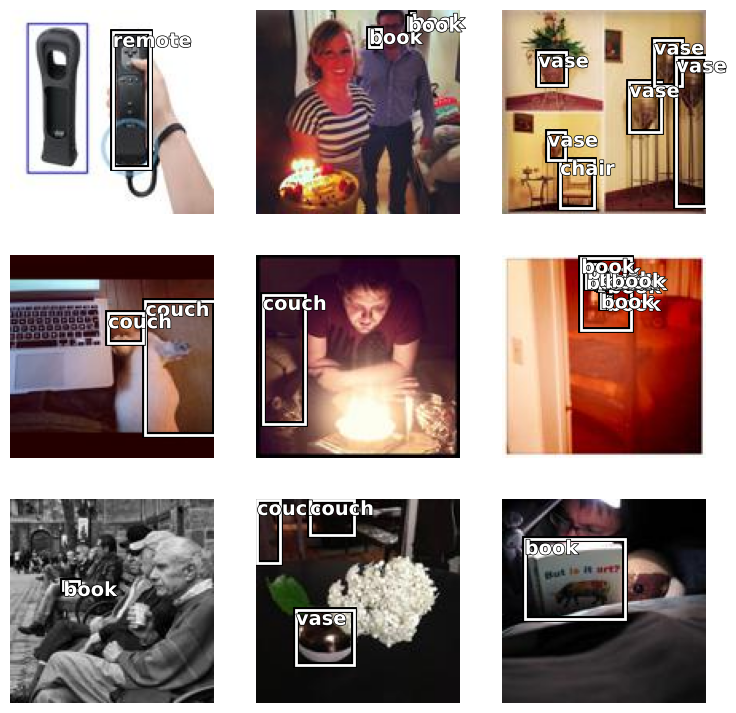

In [ ]:
dls.show_batch()

In [ ]:
dls.vocab

['#na#', 'book', 'chair', 'couch', 'remote', 'tv', 'vase']

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)

In [ ]:
learn.model[-1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): fastai.layers.Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=8, bias=False)
)

In [ ]:
head_reg4 = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(8192,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256,4+len(dls.vocab))
)

def detn_loss(preds, bb_t, c_t):
    bb_i, c_i = preds[:, :4], preds[:, 4:]
    bb_i = F.sigmoid(bb_i)*128  # image is 128 by 128 pixels
    return F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t)*20

def detn_l1(preds, bb_t, _):  # just the l1 part
    bb_i = preds[:, :4]
    bb_i = F.sigmoid(bb_i)*128
    return F.l1_loss(bb_i, bb_t)

def detn_acc(preds, _, c_t):
    c_i = preds[:, 4:]
    return accuracy(c_i, c_t)

learn = vision_learner(dls, resnet18,
                       opt_func=Adam,
                       custom_head=head_reg4,
                       loss_func=detn_loss,
                       metrics=[detn_loss, detn_l1])

In [ ]:
learn.model[-1]

Sequential(
  (0): fastai.layers.Flatten(full=False)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=8192, out_features=256, bias=True)
  (4): ReLU()
  (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=256, out_features=11, bias=True)
)

In [ ]:
learn.lr_find()

/var/folders/_4/7wdh8p7x7fs7_2r_54cgjqbc0000gn/T/ipykernel_3813/2131526698.py:15: UserWarning: Using a target size (torch.Size([64, 14, 4])) that is different to the input size (torch.Size([64, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t)*20


RuntimeError: The size of tensor a (64) must match the size of tensor b (14) at non-singleton dimension 1

In [ ]:
%debug

> /Users/afonsomm/micromamba/envs/fastai/lib/python3.11/site-packages/torch/functional.py(76)broadcast_tensors()
     74     if has_torch_function(tensors):
     75         return handle_torch_function(broadcast_tensors, tensors, *tensors)
---> 76     return _VF.broadcast_tensors(tensors)  # type: ignore[attr-defined]
     77 
     78 



ipdb>  u


> /Users/afonsomm/micromamba/envs/fastai/lib/python3.11/site-packages/torch/nn/functional.py(3308)l1_loss()
   3306         reduction = _Reduction.legacy_get_string(size_average, reduce)
   3307 
-> 3308     expanded_input, expanded_target = torch.broadcast_tensors(input, target)
   3309     return torch._C._nn.l1_loss(expanded_input, expanded_target, _Reduction.get_enum(reduction))
   3310 



ipdb>  u


> /var/folders/_4/7wdh8p7x7fs7_2r_54cgjqbc0000gn/T/ipykernel_3813/2131526698.py(15)detn_loss()
     13     bb_i, c_i = preds[:, :4], preds[:, 4:]
     14     bb_i = F.sigmoid(bb_i)*128  # image is 128 by 128 pixels
---> 15     return F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t)*20
     16 
     17 def detn_l1(preds, bb_t, _):  # just the l1 part



ipdb>  p bb_i


tensor([[  2.5690, 126.5608,  12.2262,   0.8903],
        [ 83.7336,  85.0326,  64.7407,  76.1727],
        [ 64.6766, 111.4995,  19.7183,  69.8209],
        [ 51.6426,   6.5306,  45.8705,  41.5545],
        [114.8880, 121.6299,  90.3614,  69.2738],
        [ 76.4227,   0.5352, 104.9488,  51.9038],
        [ 86.1045, 104.7017,   9.7632, 107.6523],
        [ 24.7586,   5.0934, 114.4475,   3.6471],
        [ 76.4809,  76.1711,  39.5690, 115.7612],
        [ 97.1152,  55.4078,  89.1299,   3.1915],
        [  4.7277,  21.2320,  98.1994,   7.6814],
        [106.3805,  95.2271, 107.1801, 109.7481],
        [ 73.9499,  80.7414, 101.5001,  91.9095],
        [120.0499,  89.6627,  52.1363,  63.6621],
        [  2.1994,  20.2039,  69.5678,  70.9486],
        [ 62.5240,  52.8380,   7.1984,  83.9535],
        [ 61.6595,  48.1466,  86.4160,  73.2695],
        [ 83.7826,   5.9919,  52.4612,  85.7278],
        [ 25.4882,  81.8930,  69.5977,  97.0957],
        [ 14.6698,  45.6408, 112.7496,  25.0879],


ipdb>  p bb_ishape


*** NameError: name 'bb_ishape' is not defined


ipdb>  p bb_i.shape


torch.Size([64, 4])


ipdb>  p bb_t.shape


torch.Size([64, 14, 4])


# Chromosome Karyotype Dataset

- https://www.kaggle.com/datasets/aliabedimadiseh/chromosome-image-dataset-karyotype/data

In [ ]:
import os

In [ ]:
os.listdir("./data")

['weight',
 'single_chromosomes_object',
 '.DS_Store',
 'diff_image.txt',
 'train.txt',
 'structural_abnormalities.csv',
 'normal.csv',
 '24_chromosomes_object',
 'Readme.txt',
 'test.txt',
 'number_abnormalities.csv']

In [ ]:
!pip install lxml

In [ ]:
def get_labels(xml_path):
    return pd.read_xml(xml_path, xpath="/annotation/object")["name"]

def get_bboxs(xml_path):
    return pd.read_xml(xml_path, xpath="/annotation/object/bndbox")

In [ ]:
labels = get_labels("./data/24_chromosomes_object/annotations/103064.xml")
bboxs = get_bboxs("./data/24_chromosomes_object/annotations/103064.xml")

In [ ]:
display(labels.head())
display(bboxs.head())

0    A1
1    A1
2    A2
3    A2
4    A3
Name: name, dtype: object

xmin  ymin  xmax  ymax
0   237   274   303   393
1    91   205   200   302
2   378   214   464   281
3   144   313   205   419
4   169   248   243   322